# Large Movie Deconvolution
This notebook is the beginning of some experiments in deconvoluting a large movie (namely, the sample provided by Shay). The main challenge presented here is that you aren't able to load the entire movie into memory, process it frame by frame to generate another huge ndarray in memory, and then dump that second huge ndarray into a `.tif` file. Instead, you want to loop over all frames, load one frame at a time, process that one frame, and then dump the processed frame directly into the output file. That output file should be a "raw" 2 byte-per-pixel movie, essentially the same as an `.isxd` file but without the json metadata at the end.

## Before Starting:
Make sure you download the appropropriate movie:
```
/ariel/Data2/standard_datasets/striatum/inscopix/IM1/20180402/pipeline/recording_20180402_094031-PP-bp-mc.isxd
```
and put it into `MultiWienerNet/data`.

Then, go through running this notebook.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
sys.path.append("../common/")
import isxd_reader
import denoising

Below, we are defining some stuff that we use later when loading the movie and padding it appropriately.

In [2]:
# this is the standard movie of the striatum, spatially bandpassed
standard_movie_path = "../data/recording_20180402_094031-PP-bp-mc.isxd"

# some additional information about this movie
# the dimensions of the movie
dimensions = (526,636)
# the amount of metadata between frames (there is none)
metadata_size=(0,0)

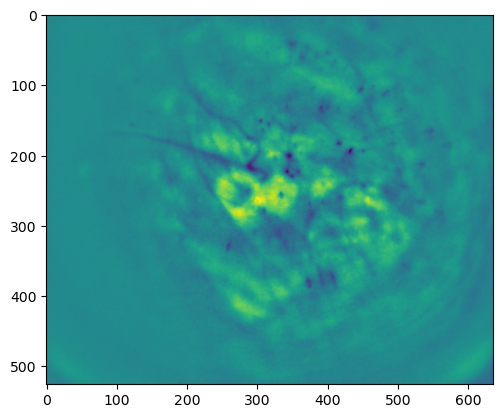

In [3]:
frame_100 = isxd_reader.load_image2(standard_movie_path, index=1000, dimensions=dimensions, metadata_size=metadata_size)
plt.imshow(frame_100)

Below: getting the number of frames by subtracting the size of the metadata from the size of the file, and then dividing the size of the file by the size of a frame

In [4]:
file_size = os.path.getsize(standard_movie_path)
with open(standard_movie_path, 'rb') as file:
    # get metadata size
    file.seek(-8, 2)
    metadata_json_size = int.from_bytes(file.read(8), byteorder='little')
    data_size = file_size - metadata_json_size - 9 # metadata is followed by an extra '\0' byte and then 8 bytes of size count
    num_frames = data_size//int(2*dimensions[0]*dimensions[1] + metadata_size[0] + metadata_size[1])
    file.seek(0)

In [5]:
metadata_json_size

1115

In [6]:
num_frames

35992

I want to process the entire movie. For that, I want to load the whole thing frame-by-frame, process each frame, and write it out to a file.

First, load the neural network in question:

In [7]:
import preset_nn

# the model that you create has to match the saved weights
# the default created by instant_multiwienernet is the same as noisy5.
# However, you may want to use e.g. blurpools as per Zhang, 2019.
# In that case, you may want to use something like the commented-out line:
# model = preset_nn.instant_multiwienernet(pooling='averageblur')
model = preset_nn.instant_multiwienernet()

# replace this with the path to the model weights that you save
weights_path = "saved_models/multiwiener_nV3_probe_noisy5/model_weights"

model.load_weights(weights_path)

2023-05-01 10:22:27.217918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:22:27.388892: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-01 10:22:27.422768: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-01 10:22:29.403802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Now, create the output file and go through the input file frame by frame, pad each one (since it was cropped before I got it) and pass it through the neural network. Write each of these frames into the output file.

I write out the image with pixels each represented by two bytes so that it can later be loaded by the function I already wrote for loading `.ixsd` files' individual frames (namely `load_image2` as shown below).

Below, I'll only go through processing the first 100 frames to make the process fast as a demonstration. However, you could either replace the `100` in the for loop with whatever you want, or, better yet, write your own script to do the whole-movie deconvolution as presented here and run it.

In [8]:
with open('../data/outmovie.raw', 'w+b') as outfile:
    for frame in range(100):
        # print the frame we're on for peace of mind
        print("frame: " + str(frame))
        
        # load just the frame we are interested in
        in_img = isxd_reader.load_image2(standard_movie_path, index=frame, dimensions=dimensions, metadata_size=metadata_size)
        
        # pad the image to make it size (800,1280)
        in_img_padded = np.pad(in_img, ((137,137), (322,322)))
        
        # rescale all the pixel values to make them all range from 0 to 1
        in_img_scaled = denoising.rescale_to_one(in_img_padded)
        
        # pass the thing through the neural network, make it into a numpy ndarray so we can change the data type
        out_img = model(in_img_scaled.reshape((1,800,1280,1)))[0,:,:].numpy()
        
        # rescale the image so all the pixels lie on the range (0, 65535); i.e. use the full range made available by
        # two-byte pixels
        out_img_2B = (denoising.rescale_to_one(out_img)*65535).astype(np.uint16)
        
        # write the two-byte pixel image out.
        outfile.write(out_img_2B)

frame: 0


2023-05-01 10:22:37.225814: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2023-05-01 10:22:37.818020: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-01 10:22:38.030057: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-01 10:22:38.279645: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


frame: 1
frame: 2
frame: 3
frame: 4
frame: 5
frame: 6
frame: 7
frame: 8
frame: 9
frame: 10
frame: 11
frame: 12
frame: 13
frame: 14
frame: 15
frame: 16
frame: 17
frame: 18
frame: 19
frame: 20
frame: 21
frame: 22
frame: 23
frame: 24
frame: 25
frame: 26
frame: 27
frame: 28
frame: 29
frame: 30
frame: 31
frame: 32
frame: 33
frame: 34
frame: 35
frame: 36
frame: 37
frame: 38
frame: 39
frame: 40
frame: 41
frame: 42
frame: 43
frame: 44
frame: 45
frame: 46
frame: 47
frame: 48
frame: 49
frame: 50
frame: 51
frame: 52
frame: 53
frame: 54
frame: 55
frame: 56
frame: 57
frame: 58
frame: 59
frame: 60
frame: 61
frame: 62
frame: 63
frame: 64
frame: 65
frame: 66
frame: 67
frame: 68
frame: 69
frame: 70
frame: 71
frame: 72
frame: 73
frame: 74
frame: 75
frame: 76
frame: 77
frame: 78
frame: 79
frame: 80
frame: 81
frame: 82
frame: 83
frame: 84
frame: 85
frame: 86
frame: 87
frame: 88
frame: 89
frame: 90
frame: 91
frame: 92
frame: 93
frame: 94
frame: 95
frame: 96
frame: 97
frame: 98
frame: 99


load the 50th frame from the output movie (also checking that they didn't overwrite one another, etc). If this looks good, you can move this whole `.raw` file back to the PC for inspection etc.

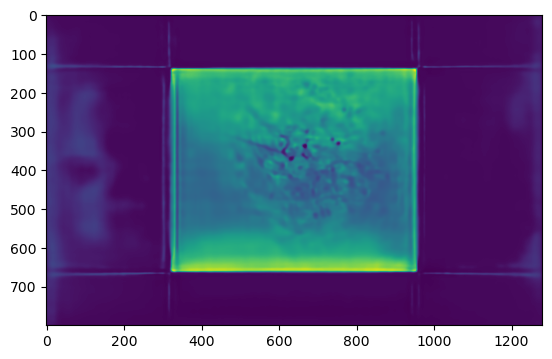

In [11]:
plt.imshow(isxd_reader.load_image2('../data/outmovie.raw', index=50, metadata_size=metadata_size, dimensions=(800,1280)))